In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read the data stored after pre-processing stage and analyze to ensure everthing looks fine

In [4]:
book_review_data = pd.read_csv("../data/interim/merged_data_ids.csv")

In [5]:
book_review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360666 entries, 0 to 360665
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Title           360666 non-null  object 
 1   description     360666 non-null  object 
 2   authors         358299 non-null  object 
 3   categories      360666 non-null  object 
 4   User_id         360666 non-null  object 
 5   Ratings         360666 non-null  float64
 6   review/summary  360415 non-null  object 
 7   review/text     360666 non-null  object 
 8   UserId          360666 non-null  int64  
 9   BookId          360666 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 27.5+ MB


In [6]:
book_review_data.sort_values(by = 'UserId').head(10)

Title  \
0                                Dr. Seuss: American Icon   
305077  Artistic License: Three Centuries of Good Writ...   
105601                    Ahab's Wife: Or, the Star-Gazer   
151308                                Heart of the Matter   
269782  OUT OF THE SILENT PLANET - The Perelandra Tril...   
244321                        Who Wrote the Book of Love?   
359042  The Woman Who Walked to Russia: A Writer's Sea...   
40133                                       Silent Spring   
49267   Ogden Nash: The Life and Work of America's Lau...   
270033  New Spring - The Novel - The Wheel Of Time, In...   

                                              description  \
0       Philip Nel takes a fascinating look into the k...   
305077  "Ms. Allen goes on to show how the incendiarie...   
105601  From the opening line—"Captain Ahab was neithe...   
151308  "Giffin excels at creating complex characters ...   
269782  Focuses on the age-old nature and consequences...   
244321  Een eeuwenoude tekst. Een bijzondere historisc...   
359042  From the moment Pybus first heard about Lillia...   
40133   Rachel Carson's Silent Spring alerted a large ...   
49267   Looks at the life, career, and writings of the...   
270033  Moirain Damodred and Lan Mandragoran must find...   

                              authors                      categories  \
0                          Philip Nel  ['Biography', 'Autobiography']   
305077                   Brooke Allen  ['Biography', 'Autobiography']   
105601             Sena Jeter Naslund                     ['Fiction']   
151308                   Emily Giffin                     ['Fiction']   
269782                     C.S. Lewis                     ['Fiction']   
244321              Kathleen MacGowan                     ['Fiction']   
359042                Cassandra Pybus                      ['Travel']   
40133                   Rachel Carson                      ['Nature']   
49267   Douglas M. Parker, Dana Gioia  ['Biography', 'Autobiography']   
270033                  Robert Jordan                     ['Fiction']   

               User_id  Ratings  \
0       A30TK6U7DNS82R      5.0   
305077  A30TK6U7DNS82R      3.0   
105601  A30TK6U7DNS82R      3.0   
151308  A30TK6U7DNS82R      4.0   
269782  A30TK6U7DNS82R      5.0   
244321  A30TK6U7DNS82R      3.0   
359042  A30TK6U7DNS82R      3.0   
40133   A30TK6U7DNS82R      5.0   
49267   A30TK6U7DNS82R      5.0   
270033  A30TK6U7DNS82R      4.0   

                                           review/summary  \
0                                       really enjoyed it   
305077                  the dentists office of literature   
105601                   a good romance for the homebound   
151308      a matter of fact book that might save my life   
269782  should have been filmed instead of the narnia ...   
244321                                 chuckles about sex   
359042                                          easypeasy   
40133                                     another thoreau   
49267                                           nashville   
270033                        missing    one kitchen sink   

                                              review/text  UserId  BookId  
0       i dont care much for dr seuss but after readin...       0       0  
305077  i hate these thrown together collections of es...       0   55023  
105601  if you are a shutin who likes to keep one eye ...       0   15312  
151308  i was lucky to stumble across an advance readi...       0   23995  
269782  it seems as though the success of the lord of ...       0   47659  
244321  lee siegels novel of a group of sex obsessed b...       0   41974  
359042  cassandra pybus an australian writer heard abo...       0   66821  
40133   rachel carson wrote so beautifully that any fe...       0    5686  
49267   loved the book ogden nash not so much as a lit...       0    7233  
270033  otherwise a new spring has everything that a r...       0   47695

In [7]:
book_review_data.sort_values(by="BookId").head(10)

Title  \
0                            Dr. Seuss: American Icon   
1                            Dr. Seuss: American Icon   
2                            Dr. Seuss: American Icon   
3               Wonderful Worship in Smaller Churches   
4   Rising Sons and Daughters: Life Among Japan's ...   
5   Muslim Women's Choices: Religious Belief and S...   
6                         Dramatica for Screenwriters   
7   Vector Quantization and Signal Compression (Th...   
10                  Eyewitness Travel Guide to Europe   
8                   Eyewitness Travel Guide to Europe   

                                          description  \
0   Philip Nel takes a fascinating look into the k...   
1   Philip Nel takes a fascinating look into the k...   
2   Philip Nel takes a fascinating look into the k...   
3   This resource includes twelve principles in un...   
4   Wardell recalls his experience as a foreign st...   
5   Counters the Western views and stereotypes of ...   
6   Dramatica for Screenwriters by Armando Saldana...   
7   Herb Caen, a popular columnist for the San Fra...   
10  The DK Eyewitness Travel Guide: Eastern and Ce...   
8   The DK Eyewitness Travel Guide: Eastern and Ce...   

                                              authors  \
0                                          Philip Nel   
1                                          Philip Nel   
2                                          Philip Nel   
3                                        David R. Ray   
4                                      Steven Wardell   
5                  Camillia Fawzi El-Solh, Judy Mabro   
6                                Armando Salda A-Mora   
7                        Allen Gersho, Robert M. Gray   
10  Dorling Kindersley Publishing Staff, Jonathan ...   
8   Dorling Kindersley Publishing Staff, Jonathan ...   

                        categories         User_id  Ratings  \
0   ['Biography', 'Autobiography']  A30TK6U7DNS82R      5.0   
1   ['Biography', 'Autobiography']  A2MVUWT453QH61      4.0   
2   ['Biography', 'Autobiography']  A2F6NONFUDB6UK      4.0   
3                     ['Religion']  A373VVEU6Z9M0N      5.0   
4               ['Social Science']  A3NIQK6ZLYEP1L      4.0   
5                     ['Religion']   ATDE9JYCPI0L1      2.0   
6                    ['Reference']  A32ZQ5DEXBL60Z      5.0   
7    ['Technology', 'Engineering']   A29Z0B2L367ZO      5.0   
10                      ['Europe']   AT9YSY20RJUDX      4.0   
8                       ['Europe']  A281NPSIMI1C2R      5.0   

                                       review/summary  \
0                                   really enjoyed it   
1     phlip nel gives silly seuss a serious treatment   
2           one of americas greatest creative talents   
3           small churches can have wonderful worship   
4                            almost a day by day view   
5                                             oh dear   
6   even as a fiction writer i found this book inv...   
7                  great reference book for its topic   
10              helpful guide on tours through europe   
8       the major sights in twenty countries  amazing   

                                          review/text  UserId  BookId  
0   i dont care much for dr seuss but after readin...       0       0  
1   theodore seuss geisel 19041991 aka quotdr seus...       1       0  
2   dr seuss american icon by philip nel is a thou...       2       0  
3   many small churches feel like they can not hav...       3       1  
4   steven wardell went to japan without reading a...       4       2  
5   i was excited to find a book ostensibly about ...       5       3  
6   i think the hardest thing for people coming to...       6       4  
7   it seems somebody was complaining for the prin...       7       5  
10  i recently took a backpack trip through europe...      10       6  
8   yes this is one heavy book it is more than lik...       8       6

### We will start building the collaborative filtering model

In [8]:
X = book_review_data[['UserId', 'BookId']]
y = book_review_data[['Ratings']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = .25, random_state = 0, stratify = book_review_data.Ratings.values)

### We will use PyTorch to build our collaborative filtering model. The first step in build a PyTorch model is to define the dataset

In [9]:
class BookReviewDataset(Dataset):
    def __init__(self, users, books, ratings):
        self.users = users
        self.books = books
        self.ratings = ratings
    
    # length will be all the reviews, which we can get using length of users
    def __len__(self):
        return len(self.users)
     
    def __getitem__(self, idx):

        users = self.users[idx] 
        books = self.books[idx]
        ratings = self.ratings[idx]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "books": torch.tensor(books, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

In [10]:
train_dataset = BookReviewDataset(
    users=X_train.UserId.values,
    books=X_train.BookId.values,
    ratings=y_train.Ratings.values
)

valid_dataset = BookReviewDataset(
    users=X_test.UserId.values,
    books=X_test.BookId.values,
    ratings=y_test.Ratings.values
)

### We will now build DataLoaders and do a manual iteration to check if it works fine

In [11]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True) 

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True) 

dataiter = iter(train_loader)
dataloader_data = next(dataiter) 
print(dataloader_data)

{'users': tensor([  206,  7921, 17288,  7647]), 'books': tensor([14755, 45117, 45244, 64896]), 'ratings': tensor([4, 4, 4, 3])}


In [12]:
class BookRecModel(nn.Module):
    def __init__(self, n_users, n_books, n_factors = 50, y_range=(0,5.5)):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embeds = nn.Embedding(n_users, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.book_embeds = nn.Embedding(n_books, n_factors)
        self.book_bias = nn.Embedding(n_books, 1)
        self.y_range = y_range

    # The sigmoid function will give a continuous output. We are building a function to change continuous output to a rating.
    # The range to convert continuous output to a rating is based on the observations from previous training of the model
    def changeOutputToRating (self,x):
        x = torch.where (x > 4.0, 5, x)
        x = torch.where (torch.logical_and(x <= 4.0, x >= 3.5), 4, x)
        x = torch.where (torch.logical_and(x < 3.5, x >= 2.8), 3, x)
        x = torch.where (torch.logical_and(x < 2.8 , x >= 2.5), 2, x)
        x = torch.where (x < 2.5, 1, x)
        return x
        
    def forward(self, users, books, ratings=None):
        user_factors = self.user_embeds(users)
        book_factors = self.book_embeds(books)
        res = (user_factors * book_factors).sum(dim = 1, keepdim = True)
        res += self.user_bias (users) + self.book_bias(books)
        return torch.sigmoid(res) * 5.5

In [13]:
unique_users = X.UserId.unique().shape[0]
unique_books = X.BookId.unique().shape[0]
print (unique_users, unique_books)

21147 67192


### We set the optimizer, learning rate and weight decay after a few experimentation

In [14]:
model = BookRecModel (n_users = unique_users, n_books = unique_books).to(device)
optimizer =  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.5) #torch.optim.Adam(model.parameters(), weight_decay=0.1)  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_func = nn.MSELoss()

In [15]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    step_cnt = 0
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"].to(device), 
                       train_data["books"].to(device)
                      ) 
        
        rating = train_data["ratings"].view(output.size()[0], -1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss


epoch 0 loss at step: 5000 is 0.2491996484041214
epoch 0 loss at step: 10000 is 0.20190004133284092
epoch 0 loss at step: 15000 is 0.20179186613857747
epoch 0 loss at step: 20000 is 0.2003826964855194
epoch 0 loss at step: 25000 is 0.20278870305940508
epoch 0 loss at step: 30000 is 0.20160535260401666
epoch 0 loss at step: 35000 is 0.20041361084729434
epoch 0 loss at step: 40000 is 0.19796643916517495
epoch 0 loss at step: 45000 is 0.20342381501495838
epoch 0 loss at step: 50000 is 0.20037027953732758
epoch 0 loss at step: 55000 is 0.19933837870508433
epoch 0 loss at step: 60000 is 0.20346150397658347
epoch 0 loss at step: 65000 is 0.20111048611700535
epoch 0 loss at step: 70000 is 0.19784862302392722
epoch 0 loss at step: 75000 is 0.1994618542253971
epoch 0 loss at step: 80000 is 0.20284968542009593
epoch 0 loss at step: 85000 is 0.20231014943867923
epoch 0 loss at step: 90000 is 0.198721219804883
epoch 0 loss at step: 95000 is 0.20127110162377357
epoch 0 loss at step: 100000 is 0.199

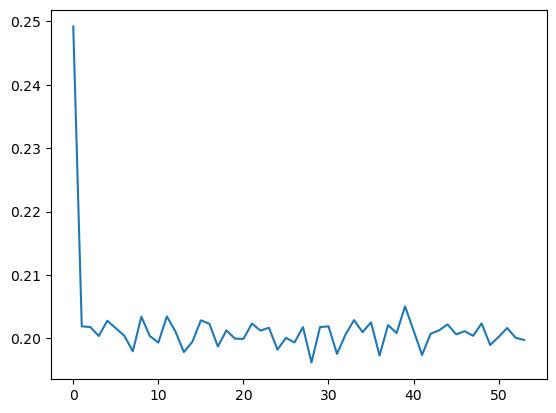

In [16]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

### Let's now evaluate the model using validation (test in this case) dataset. We will first evaluate using confusion matrix and then RMSE

### The model's output is currently continuous and we need to change it to discreet values. Below is a function that does that. The range to convert continuous output to a rating is based on the observations from previous training of the model

In [17]:
def convertOutputToRating(output):
    if (output > 4.0):
        return 5
    elif ( (output <= 4.0) and (output >= 3.5)):
        return 4
    elif (output < 3.5 and output >= 2.8):
        return 3
    elif (output < 2.8 and output > 2.5):
        return 2
    else: 
        return 1

In [18]:
model.eval()
y_pred_actual = []
y_pred_rating = []
y_actual = []    
    
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'].to(device), 
                       batched_data["books"].to(device))
        
        # Convert model ouput to numpy array
        numparray = model_output.squeeze().detach().cpu().numpy()
        
        #convert model output to ratings
        model_rating = [convertOutputToRating(x) for x in numparray]
        y_pred_actual.extend(numparray)
        y_pred_rating.extend(model_rating)
        y_actual.extend(batched_data['ratings'].detach().cpu().numpy().tolist())
        print (f"Model output {model_output} ratings from model {model_rating} actual ratings {batched_data['ratings']}" )



Model output tensor([[2.7500],
        [2.7705],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7510],
        [2.7495],
        [2.7615],
        [2.7590]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7615],
        [2.7662],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7649],
        [2.7500],
        [2.7500],
        [2.7548]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7522],
        [2.7578],
        [2.7503],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7505],
        [2.7705],
        [2.7501],
        [2.7518]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7518],
        [2.7511],
        [2.7576]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7553],
        [2.7500],
        [2.7662],
        [2.7532]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7536],
        [2.7500],
        [2.7651],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 2, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 2, 5, 5])
Model output tensor([[2.7734],
        [2.7500],
        [2.7524],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7521],
        [2.7565]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7452],
        [2.7500],
        [2.7643],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7612],
        [2.7565]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.8475],
        [2.7523],
        [2.7500]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7961],
        [2.7508],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7503],
        [2.7502],
        [2.7503],
        [2.7498]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7536],
        [2.8171],
        [2.7504],
        [2.7599]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7501],
        [2.7501],
        [2.7507]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7687],
        [2.7500],
        [2.7556],
        [2.7672]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7513],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 1, 4, 5])
Model output tensor([[2.7709],
        [2.7455],
        [2.7521],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7556],
        [2.7586],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7515],
        [2.7510],
        [2.7462],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7525],
        [2.7607],
        [2.7545],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7525],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 2, 1])
Model output tensor([[2.7453],
        [2.7500],
        [2.7655],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7506],
        [2.7500],
        [2.7714],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7456]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7690],
        [2.7536]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7519]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7549],
        [2.7500],
        [2.7649]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7516],
        [2.8171],
        [2.7500],
        [2.7526]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7500],
        [2.7501],
        [2.7524]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 4, 4, 5])
Model output tensor([[2.7719],
        [2.7520],
        [2.7500],
        [2.7511]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7516],
        [2.7764],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7503],
        [2.7503],
        [2.7606],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7472],
        [2.7500],
        [2.7744]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7585],
        [2.7500],
        [2.7591]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7518],
        [2.7490],
        [2.7500],
        [2.7624]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7420],
        [2.7504],
        [2.7644],
        [2.7550]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.7536],
        [2.7518],
        [2.7500],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 2])
Model output tensor([[2.7497],
        [2.7607],
        [2.7671],
        [2.7544]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 3, 4])
Model output tensor([[2.7500],
        [2.7662],
        [2.7500],
        [2.7491]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7564],
        [2.7536],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7790]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7688],
        [2.7606],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7508],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7552],
        [2.7691],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7531],
        [2.7602],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7543],
        [2.7615],
        [2.7500],
        [2.7732]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7526],
        [2.7509],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7603],
        [2.7500],
        [2.7505],
        [2.7583]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7537],
        [2.7501],
        [2.7567]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7549],
        [2.7498],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7600],
        [2.7532],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7581],
        [2.7500],
        [2.7514],
        [2.7839]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7671],
        [2.7639],
        [2.7507],
        [2.7540]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7636],
        [2.7688],
        [2.7517],
        [2.7353]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7816],
        [2.7519],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 1, 4])
Model output tensor([[2.7537],
        [2.7575],
        [2.7601],
        [2.7664]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 3, 5])
Model output tensor([[2.7725],
        [2.7552],
        [2.7530],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 1, 4])
Model output tensor([[2.7503],
        [2.7526],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 3, 5])
Model output tensor([[2.7664],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7621],
        [2.7543],
        [2.7500],
        [2.7593]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7521],
        [2.7618],
        [2.7816]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 2, 4, 5])
Model output tensor([[2.7536],
        [2.8171],
        [2.7534],
        [2.7500]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7693],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 3])
Model output tensor([[2.7511],
        [2.7500],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7676],
        [2.7534],
        [2.7689]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7504],
        [2.7506],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7510],
        [2.7500],
        [2.7709],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7509],
        [2.7500],
        [2.7799],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 3])
Model output tensor([[2.7607],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 2])
Model output tensor([[2.7500],
        [2.7501],
        [2.7501],
        [2.7479]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 1, 3])
Model output tensor([[2.7500],
        [2.7746],
        [2.7522],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 2])
Model output tensor([[2.7506],
        [2.7500],
        [2.7507],
        [2.7609]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7749],
        [2.7662]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 2, 5])
Model output tensor([[2.7500],
        [2.7405],
        [2.7816],
        [2.7726]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7553],
        [2.7500],
        [2.7537],
        [2.7536]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7547],
        [2.7507],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 2, 5])
Model output tensor([[2.7517],
        [2.7567],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7504],
        [2.7573]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7494]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 4, 2])
Model output tensor([[2.7500],
        [2.7868],
        [2.7500],
        [2.7527]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7546],
        [2.7541],
        [2.7568]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7635],
        [2.7499],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7800],
        [2.7507],
        [2.7662]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7534],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7503],
        [2.7500],
        [2.7501],
        [2.8230]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7530],
        [2.7543],
        [2.7597],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 4, 2])
Model output tensor([[2.7667],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7502],
        [2.7830]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7531],
        [2.7550],
        [2.7554],
        [2.7515]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7588],
        [2.7571],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7691],
        [2.7559],
        [2.7510],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7563],
        [2.7503],
        [2.7500],
        [2.7542]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7528],
        [2.7511],
        [2.7524],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7551],
        [2.7500],
        [2.7521],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7647],
        [2.7500],
        [2.7503],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7592],
        [2.7501],
        [2.7500],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 3])
Model output tensor([[2.7589],
        [2.7528],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7509],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7765],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7532],
        [2.7503],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7509],
        [2.7518],
        [2.7500],
        [2.7495]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7513],
        [2.7501],
        [2.7499],
        [2.7692]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7517],
        [2.7510],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7502],
        [2.7674],
        [2.7500],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7618],
        [2.7500],
        [2.7536]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7511],
        [2.7507],
        [2.7567]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7518],
        [2.7512],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7560],
        [2.7502],
        [2.7608],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7514],
        [2.7506],
        [2.7596],
        [2.7777]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7876],
        [2.7511],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7514],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7697],
        [2.7662],
        [2.7570],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7511],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7502],
        [2.7645],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7653],
        [2.7495],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 2, 5])
Model output tensor([[2.7507],
        [2.7504],
        [2.7506],
        [2.7519]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7575],
        [2.7676],
        [2.7500],
        [2.7494]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 3, 5])
Model output tensor([[2.7556],
        [2.7566],
        [2.7556],
        [2.7800]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7554],
        [2.7500],
        [2.7514],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7584]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7697],
        [2.7508],
        [2.7539],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7714],
        [2.7877],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.8069],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7583],
        [2.7588],
        [2.7541]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 1, 2])
Model output tensor([[2.7544],
        [2.7498],
        [2.7517],
        [2.7544]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7501],
        [2.7636],
        [2.7437],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.7507],
        [2.7515],
        [2.7693],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7570],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 3, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7434]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7816],
        [2.7500],
        [2.7695],
        [2.7556]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7508],
        [2.8171],
        [2.7872],
        [2.7500]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7534],
        [2.7671],
        [2.7640]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7563],
        [2.7621],
        [2.7500],
        [2.7535]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 2, 2])
Model output tensor([[2.8150],
        [2.7500],
        [2.7518],
        [2.7503]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 4, 2, 5])
Model output tensor([[2.7664],
        [2.7500],
        [2.7533],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7545],
        [2.7500],
        [2.7500],
        [2.7581]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7680],
        [2.7518],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 3, 5, 5])
Model output tensor([[2.7724],
        [2.7546],
        [2.7500],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7551],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7710],
        [2.7506],
        [2.7754]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7504],
        [2.7501],
        [2.7610],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7778],
        [2.7601],
        [2.7642]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7630],
        [2.7500],
        [2.7500],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 2, 5])
Model output tensor([[2.7536],
        [2.7500],
        [2.7569],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7520],
        [2.7589],
        [2.7500],
        [2.7565]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7518],
        [2.7622],
        [2.7500],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7550],
        [2.7590],
        [2.7575],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7513],
        [2.7528]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.8172],
        [2.7536],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7520],
        [2.7552],
        [2.7500],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7502],
        [2.7549],
        [2.7501],
        [2.7499]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 3])
Model output tensor([[2.7714],
        [2.7508],
        [2.7663],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7486],
        [2.7500],
        [2.7500],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7517],
        [2.7709]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7508],
        [2.7643],
        [2.7525],
        [2.7602]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7541],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7559],
        [2.7501],
        [2.8475],
        [2.7515]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([4, 1, 5, 4])
Model output tensor([[2.7516],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7531],
        [2.7588],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7528],
        [2.7499],
        [2.7867]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7492],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7505],
        [2.7530],
        [2.7505],
        [2.7713]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 1, 5])
Model output tensor([[2.7500],
        [2.7675],
        [2.7500],
        [2.7588]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7630],
        [2.7526],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7588],
        [2.7495],
        [2.7504],
        [2.7690]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7502],
        [2.7687],
        [2.7508],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7855],
        [2.7777],
        [2.7660],
        [2.7561]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.8171],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7522],
        [2.7533],
        [2.7536],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7832],
        [2.7472],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 1, 5, 5])
Model output tensor([[2.7498],
        [2.7503],
        [2.7772],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7509],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 2, 4, 4])
Model output tensor([[2.7534],
        [2.7680],
        [2.7577],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7631]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7586],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7725],
        [2.8076],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.8475],
        [2.7505],
        [2.7481],
        [2.7501]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7513],
        [2.7500],
        [2.7500],
        [2.7692]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 3, 5, 3])
Model output tensor([[2.7575],
        [2.7655],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7631],
        [2.7503],
        [2.7609]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7565],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7502],
        [2.7603],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7597],
        [2.7500],
        [2.7543],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7569],
        [2.7515],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7574],
        [2.7504],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7502],
        [2.7673],
        [2.7505],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7511],
        [2.7588],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7526],
        [2.7531],
        [2.7465]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 1])
Model output tensor([[2.7500],
        [2.7583],
        [2.7500],
        [2.7543]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7557],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7729],
        [2.7526],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 2])
Model output tensor([[2.7500],
        [2.7542],
        [2.7536],
        [2.7604]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 2])
Model output tensor([[2.8150],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual rat

Model output tensor([[2.7507],
        [2.7607],
        [2.7664],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 2, 5])
Model output tensor([[2.7533],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7518],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7534],
        [2.7595],
        [2.7521],
        [2.7674]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7504],
        [2.7649],
        [2.7500],
        [2.7521]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7505],
        [2.7503],
        [2.7581],
        [2.7623]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7641],
        [2.7656],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.8158],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7543],
        [2.7616],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7575],
        [2.7511],
        [2.7589]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7499],
        [2.7500],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7617]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.8475],
        [2.7671],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([3, 4, 3, 3])
Model output tensor([[2.7501],
        [2.7633],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7597]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7505],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7580],
        [2.7506],
        [2.7539]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 4, 4])
Model output tensor([[2.7503],
        [2.7478],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7605],
        [2.7541],
        [2.7540],
        [2.7644]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.8475],
        [2.7536],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7518],
        [2.7544],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7547],
        [2.7888],
        [2.7500],
        [2.7566]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7530],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 3])
Model output tensor([[2.7778],
        [2.7537],
        [2.7518],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7573],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7476],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7570],
        [2.7500],
        [2.7501],
        [2.7705]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7508],
        [2.7500],
        [2.7500],
        [2.7658]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7531],
        [2.7500],
        [2.7491],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7503],
        [2.7523],
        [2.7500],
        [2.7546]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7504],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7530]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7520],
        [2.7517],
        [2.7507],
        [2.7650]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7688],
        [2.7511],
        [2.7800],
        [2.7533]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7603],
        [2.7506],
        [2.7641]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7586],
        [2.7612],
        [2.7518],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7517],
        [2.7500],
        [2.7672]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7513],
        [2.7647],
        [2.7505],
        [2.7551]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 4, 4])
Model output tensor([[2.7514],
        [2.7503],
        [2.7519],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 2, 5, 4])
Model output tensor([[2.7888],
        [2.7500],
        [2.7659],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 3, 2])
Model output tensor([[2.7501],
        [2.7556],
        [2.7500],
        [2.7565]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7521],
        [2.7690],
        [2.7575]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7616],
        [2.7504],
        [2.7644],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7501],
        [2.7498],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7571],
        [2.7820]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7689],
        [2.7465],
        [2.7517],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7518],
        [2.7831],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7576],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 4, 5])
Model output tensor([[2.7503],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7509],
        [2.7511],
        [2.8475],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7522],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7506],
        [2.7522],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7514],
        [2.8475],
        [2.7526],
        [2.7500]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7522],
        [2.7500],
        [2.7816]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7709],
        [2.7503],
        [2.7530],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7503],
        [2.7548],
        [2.7506],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7575],
        [2.7484],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[2.7507],
        [2.7522],
        [2.7500],
        [2.7901]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7504],
        [2.7500],
        [2.7575]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7494],
        [2.7529],
        [2.7500],
        [2.7515]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 3, 4])
Model output tensor([[2.7530],
        [2.7746],
        [2.7816],
        [2.7507]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7517],
        [2.7498],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7537],
        [2.7500],
        [2.7663],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7658],
        [2.7522],
        [2.7795]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7570],
        [2.7633],
        [2.8171]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7435],
        [2.7501],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7894],
        [2.7500],
        [2.7531]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7681],
        [2.7621]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7519],
        [2.7507],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7576],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7546],
        [2.7500],
        [2.7475],
        [2.7480]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7706],
        [2.7500],
        [2.7576],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7652],
        [2.7512],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7531],
        [2.7660],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 3])
Model output tensor([[2.7500],
        [2.7504],
        [2.7641],
        [2.7545]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7718],
        [2.7603],
        [2.7500],
        [2.7564]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7529],
        [2.7500],
        [2.7523],
        [2.7901]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7662],
        [2.7500],
        [2.7703],
        [2.7598]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7607],
        [2.7656],
        [2.7500],
        [2.7605]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7547],
        [2.7581]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 2, 5])
Model output tensor([[2.7534],
        [2.7512],
        [2.7500],
        [2.8475]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7606],
        [2.7500],
        [2.7746],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7511],
        [2.7481],
        [2.7500],
        [2.7518]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7572],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7500],
        [2.7668]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7687],
        [2.7824]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7554],
        [2.7505],
        [2.7511],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7553],
        [2.7502],
        [2.7500],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7626],
        [2.7589],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7503],
        [2.7408],
        [2.7519],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 3])
Model output tensor([[2.7585],
        [2.7575],
        [2.7501],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7547],
        [2.7597],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7538],
        [2.7500],
        [2.7518],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7630],
        [2.7577],
        [2.7474],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7522],
        [2.7500],
        [2.7401],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7535],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7524],
        [2.7509],
        [2.7500],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7888],
        [2.7534],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7589],
        [2.7657],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7738],
        [2.8171],
        [2.7575]], device='cuda:0') ratings from model [2, 2, 3, 2] actual rat

Model output tensor([[2.7509],
        [2.7816],
        [2.7500],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7574],
        [2.7686],
        [2.7521],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 3, 5])
Model output tensor([[2.7501],
        [2.7787],
        [2.7500],
        [2.7548]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7565],
        [2.7527],
        [2.7796],
        [2.7531]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7567],
        [2.7504],
        [2.7660],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7508],
        [2.7578],
        [2.7504],
        [2.7679]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7517],
        [2.7549]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7714],
        [2.7526],
        [2.7500],
        [2.7404]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 2, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7528],
        [2.7776]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7728],
        [2.7501],
        [2.7455]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7697],
        [2.7500],
        [2.7526],
        [2.7532]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7459],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7594],
        [2.7503],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7674],
        [2.7500],
        [2.7483],
        [2.7541]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7673],
        [2.7502],
        [2.7500],
        [2.7483]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7500],
        [2.7637],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7514],
        [2.7674],
        [2.7516],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7537],
        [2.7709],
        [2.7569]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7662],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 3, 5])
Model output tensor([[2.7551],
        [2.7500],
        [2.7604],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7551],
        [2.7507],
        [2.7571],
        [2.7765]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 2, 5])
Model output tensor([[2.7502],
        [2.7520],
        [2.7640],
        [2.7738]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 1])
Model output tensor([[2.7507],
        [2.7681],
        [2.7500],
        [2.7518]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7514],
        [2.7500],
        [2.7519],
        [2.7569]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7481],
        [2.7705],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7504],
        [2.7593],
        [2.7500],
        [2.8475]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7712],
        [2.7480],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7843],
        [2.7831],
        [2.7685],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7570],
        [2.7517],
        [2.7690],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7515],
        [2.7624],
        [2.7500],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7509],
        [2.7634],
        [2.7540]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 2, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7688],
        [2.7546]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7696]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7726],
        [2.7533],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 2, 4, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7594]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7506],
        [2.7504],
        [2.7500],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7686],
        [2.7500],
        [2.7709],
        [2.7719]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7517],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7675],
        [2.7555]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7434],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7832],
        [2.7498],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7501],
        [2.7500],
        [2.7570],
        [2.7548]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7504],
        [2.7504],
        [2.7574],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7603],
        [2.7500],
        [2.7492],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7533],
        [2.7690],
        [2.7724]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7646],
        [2.7519],
        [2.7513],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7532],
        [2.7510],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7555],
        [2.7501],
        [2.7505],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7563],
        [2.7555],
        [2.7500],
        [2.7532]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7705],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7475],
        [2.7500],
        [2.7534]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7529],
        [2.7690],
        [2.7667],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7639],
        [2.7758],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 1, 5, 3])
Model output tensor([[2.8069],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7501],
        [2.7500],
        [2.7771],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7508],
        [2.7723],
        [2.7444]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7502],
        [2.7517],
        [2.7601],
        [2.7560]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7495],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7518],
        [2.7501],
        [2.7500],
        [2.7575]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7504],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 1])
Model output tensor([[2.7719],
        [2.7621],
        [2.7505],
        [2.8171]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([2, 5, 4, 3])
Model output tensor([[2.7508],
        [2.7778],
        [2.7764],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7584],
        [2.7508],
        [2.7501],
        [2.7487]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7636],
        [2.7607],
        [2.7500],
        [2.7564]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 3])
Model output tensor([[2.7455],
        [2.7517],
        [2.7555],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7684],
        [2.7522],
        [2.7512],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7511],
        [2.7504],
        [2.7500],
        [2.7642]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7563],
        [2.7500],
        [2.8171],
        [2.7575]], device='cuda:0') ratings from model [2, 2, 3, 2] actual rat

Model output tensor([[2.7500],
        [2.7551],
        [2.7833],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7576],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 5, 1])
Model output tensor([[2.7500],
        [2.7507],
        [2.7500],
        [2.7650]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7565],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7575]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7511],
        [2.7570],
        [2.7764],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7489],
        [2.7529],
        [2.7504],
        [2.7745]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 4, 5, 5])
Model output tensor([[2.7568],
        [2.7511],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 3])
Model output tensor([[2.7496],
        [2.7500],
        [2.7536],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7501],
        [2.7708],
        [2.7504],
        [2.7562]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7643],
        [2.7607],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7634],
        [2.7500],
        [2.7501],
        [2.7515]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 2, 4])
Model output tensor([[2.7500],
        [2.7511],
        [2.7513],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7517],
        [2.7508],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 2, 4])
Model output tensor([[2.7690],
        [2.7512],
        [2.7499],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7507],
        [2.7503],
        [2.7500],
        [2.7497]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7488],
        [2.7501],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7503],
        [2.7513],
        [2.7500],
        [2.7604]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 2])
Model output tensor([[2.7440],
        [2.7444],
        [2.7565],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7741],
        [2.7616],
        [2.8475]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7559],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7510],
        [2.7517],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7501],
        [2.7650],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7440],
        [2.7534],
        [2.7500],
        [2.7483]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7526],
        [2.7733]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7669],
        [2.7687],
        [2.7519],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 3])
Model output tensor([[2.7534],
        [2.7765],
        [2.7500],
        [2.7690]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7533],
        [2.7515],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7578],
        [2.7521]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7515],
        [2.7568]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7501],
        [2.7664],
        [2.7680],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7707],
        [2.7500],
        [2.7765],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7567],
        [2.7500],
        [2.7572],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7506],
        [2.7563],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 2, 5])
Model output tensor([[2.7888],
        [2.7540],
        [2.7505],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7673],
        [2.7500],
        [2.7500],
        [2.7518]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 2, 1])
Model output tensor([[2.7500],
        [2.7536],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7504],
        [2.7500],
        [2.7520],
        [2.7675]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 3])
Model output tensor([[2.7500],
        [2.7519],
        [2.7500],
        [2.7545]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7505],
        [2.7541],
        [2.7501],
        [2.7532]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7618],
        [2.7500],
        [2.7540],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7727],
        [2.7505],
        [2.7542],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7509],
        [2.7831]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 1])
Model output tensor([[2.7550],
        [2.7508],
        [2.7512],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7549],
        [2.7614],
        [2.7643]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7707],
        [2.7521],
        [2.7515],
        [2.7541]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7596],
        [2.7500],
        [2.7569],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 3])
Model output tensor([[2.8171],
        [2.7500],
        [2.7537],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([4, 1, 5, 4])
Model output tensor([[2.7554],
        [2.8150],
        [2.7500],
        [2.7697]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7554],
        [2.7503],
        [2.7702]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7649],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7501],
        [2.7709],
        [2.7524]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7705]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7602],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7519],
        [2.7520],
        [2.7769],
        [2.7533]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7736],
        [2.7816],
        [2.7552],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7508],
        [2.7598],
        [2.7603],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7610],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7557],
        [2.7534],
        [2.7506],
        [2.7379]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7541],
        [2.7522],
        [2.7945],
        [2.7764]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7901],
        [2.7708]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 4, 2])
Model output tensor([[2.7500],
        [2.7550],
        [2.7507],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7616],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7509],
        [2.7675]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7512],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7523],
        [2.7515],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7557],
        [2.7508],
        [2.7563]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7697],
        [2.7493],
        [2.7500],
        [2.7712]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7499],
        [2.7500],
        [2.7535],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 2, 5, 5])
Model output tensor([[2.7516],
        [2.7509],
        [2.7566],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7734],
        [2.7500],
        [2.7594],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7506],
        [2.7562],
        [2.7541],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[2.7800],
        [2.7506],
        [2.7418],
        [2.7683]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7513],
        [2.7531],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7607],
        [2.7515],
        [2.7581],
        [2.7702]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7584],
        [2.7583],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7690],
        [2.7764],
        [2.7554]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7664],
        [2.7500],
        [2.7509],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7540],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7517],
        [2.7509],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.8171],
        [2.7500],
        [2.7757],
        [2.7548]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([1, 5, 5, 3])
Model output tensor([[2.7516],
        [2.7690],
        [2.7833],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7505],
        [2.7516],
        [2.7709],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.7501],
        [2.7502],
        [2.7500],
        [2.7744]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7511],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7665],
        [2.7693],
        [2.7517],
        [2.7637]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7549],
        [2.7500],
        [2.8150],
        [2.7567]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7678]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 3, 2])
Model output tensor([[2.7560],
        [2.7500],
        [2.7518],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7612],
        [2.7500],
        [2.7554],
        [2.7595]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 3, 4])
Model output tensor([[2.7501],
        [2.8069],
        [2.7500],
        [2.7631]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7729],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7617],
        [2.7500],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7636],
        [2.7501],
        [2.7506],
        [2.7755]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7503],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7489],
        [2.7500],
        [2.7440],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7485],
        [2.7516],
        [2.7500],
        [2.7482]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7742],
        [2.7507],
        [2.7563],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7620],
        [2.7500],
        [2.7621]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.7500],
        [2.7585],
        [2.7518],
        [2.7640]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7501],
        [2.7508],
        [2.7455],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7511],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7591],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7526],
        [2.7500],
        [2.7500],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7514],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7481]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7765],
        [2.7500],
        [2.7500],
        [2.7574]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7511],
        [2.7618],
        [2.7500],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7510],
        [2.7500],
        [2.7500],
        [2.7536]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7613],
        [2.7500],
        [2.7800]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7593]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7645],
        [2.7598],
        [2.7482]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7674],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7658],
        [2.8069]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7482],
        [2.7504],
        [2.7568]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7522],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7663],
        [2.7500],
        [2.7757],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7818],
        [2.7500],
        [2.7500],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 3])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7620],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 1, 3])
Model output tensor([[2.7515],
        [2.7498],
        [2.7512],
        [2.7507]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7514],
        [2.7500],
        [2.7500],
        [2.7633]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7688],
        [2.7501],
        [2.7572],
        [2.7589]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7506],
        [2.7500],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7585],
        [2.7500],
        [2.7500],
        [2.7841]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7551],
        [2.7533],
        [2.7518],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 2, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7877],
        [2.7633]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7476],
        [2.7503],
        [2.7500],
        [2.7543]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7492],
        [2.7691]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 1, 4])
Model output tensor([[2.7694],
        [2.7552],
        [2.7671],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7523],
        [2.7500],
        [2.7662]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7816],
        [2.7673],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 3, 4])
Model output tensor([[2.7514],
        [2.7705],
        [2.7605],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7503],
        [2.7500],
        [2.7506],
        [2.7691]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7535],
        [2.7641]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7596],
        [2.7526],
        [2.7565],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 1])
Model output tensor([[2.7534],
        [2.7657],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7640],
        [2.7660],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7662],
        [2.7508],
        [2.7500],
        [2.7564]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 1, 4])
Model output tensor([[2.7855],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7551],
        [2.7511],
        [2.7519],
        [2.7577]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7551],
        [2.7501],
        [2.7500],
        [2.7636]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7550],
        [2.7504],
        [2.7474],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7505],
        [2.7523],
        [2.7726],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7844],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7677]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7546],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7612],
        [2.7599]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 1, 4])
Model output tensor([[2.7726],
        [2.7575],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7544],
        [2.7798],
        [2.7511],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 2])
Model output tensor([[2.7500],
        [2.7475],
        [2.7500],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7602],
        [2.7505],
        [2.7691],
        [2.7617]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 2])
Model output tensor([[2.7868],
        [2.7500],
        [2.7500],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7532],
        [2.7519],
        [2.7497],
        [2.7644]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7547],
        [2.7539],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7531]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.8171]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7636],
        [2.7583],
        [2.7559],
        [2.7511]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7505],
        [2.7500],
        [2.7653],
        [2.7499]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 4, 5, 3])
Model output tensor([[2.7800],
        [2.7500],
        [2.7500],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7684],
        [2.7517],
        [2.7503],
        [2.7559]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7529],
        [2.7664],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7512],
        [2.7500],
        [2.7523],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7516],
        [2.7508],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7541],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.7563],
        [2.7681],
        [2.7761],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7657],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7509],
        [2.7567],
        [2.7800]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7553],
        [2.7622],
        [2.7500],
        [2.7541]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7825],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.8150],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7633],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 1, 3])
Model output tensor([[2.7500],
        [2.7505],
        [2.7523],
        [2.7533]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7725],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7501],
        [2.8474],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7507],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7506],
        [2.7522],
        [2.7611]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7601],
        [2.7500],
        [2.7520],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7581],
        [2.7573],
        [2.7831],
        [2.7650]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7566],
        [2.7533],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7888],
        [2.7603],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7519]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.8171],
        [2.7500],
        [2.7583],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7511],
        [2.7542],
        [2.7508],
        [2.7477]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7690],
        [2.7500],
        [2.7765],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7499],
        [2.7500],
        [2.7500],
        [2.7485]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7502],
        [2.7502],
        [2.7500],
        [2.7616]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7573],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7519],
        [2.7542],
        [2.7500],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7558]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7475],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7527]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 4, 5, 5])
Model output tensor([[2.7507],
        [2.7598],
        [2.7630],
        [2.7605]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7607],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7522],
        [2.7500],
        [2.7957],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7514],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7510],
        [2.7540],
        [2.7709],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7502],
        [2.7530],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7546],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7521],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 2])
Model output tensor([[2.7511],
        [2.7500],
        [2.7616],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 2])
Model output tensor([[2.7500],
        [2.7517],
        [2.7637],
        [2.7639]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7499],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7776]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7602],
        [2.7631]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7525],
        [2.7500],
        [2.7528],
        [2.7679]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7518],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7504],
        [2.7549],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7519],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7519],
        [2.7657],
        [2.7516],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7506],
        [2.7500],
        [2.8475],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7482],
        [2.7500],
        [2.7455]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7656],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7571],
        [2.7500],
        [2.7501],
        [2.7511]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7617]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7592],
        [2.7500],
        [2.7657]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7496],
        [2.7500],
        [2.8150]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7590],
        [2.7500],
        [2.7639]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 3, 4, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7597],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 4, 1])
Model output tensor([[2.7537],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7533],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7491],
        [2.7671],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7639],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7699],
        [2.7559],
        [2.7500],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7507],
        [2.7500],
        [2.7467],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7533],
        [2.7694],
        [2.7539],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 4, 4])
Model output tensor([[2.7437],
        [2.7503],
        [2.7500],
        [2.7530]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7724],
        [2.7544],
        [2.7621]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7591],
        [2.7514],
        [2.7516],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7557],
        [2.7401],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7521],
        [2.7499],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7434],
        [2.7511],
        [2.7500],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7506],
        [2.7505],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7579],
        [2.7479],
        [2.7500],
        [2.7642]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7529],
        [2.7686],
        [2.7535],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7557],
        [2.8152],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7545],
        [2.7512],
        [2.7776]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7550],
        [2.7500],
        [2.7500],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7512],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7516],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 2])
Model output tensor([[2.7565],
        [2.7504],
        [2.7565],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7445],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7543],
        [2.7500],
        [2.7692],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 3, 5, 1])
Model output tensor([[2.7521],
        [2.7516],
        [2.7502],
        [2.7675]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7519],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7596],
        [2.7506],
        [2.8150],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7707],
        [2.7669],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7595],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 1, 4, 5])
Model output tensor([[2.7501],
        [2.7504],
        [2.7500],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7510],
        [2.7498],
        [2.8475]], device='cuda:0') ratings from model [2, 2, 2, 3] actual rat

Model output tensor([[2.7630],
        [2.7505],
        [2.7537],
        [2.7604]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7643],
        [2.7519],
        [2.7548],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 1])
Model output tensor([[2.8475],
        [2.7487],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7791],
        [2.7500],
        [2.7500],
        [2.7539]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7713],
        [2.7669],
        [2.7501],
        [2.7534]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7704],
        [2.7535],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.8171],
        [2.7709],
        [2.7500],
        [2.7534]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7517],
        [2.7529],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7529],
        [2.7500],
        [2.7532],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.7500],
        [2.7519],
        [2.7504],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7523],
        [2.7482]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7521],
        [2.7504],
        [2.7518],
        [2.7498]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 2])
Model output tensor([[2.7536],
        [2.7575],
        [2.7483],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7603],
        [2.7575],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7539],
        [2.7500],
        [2.7688],
        [2.7569]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7888],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7664],
        [2.7521]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7502],
        [2.7671],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7505],
        [2.7510],
        [2.7500],
        [2.7662]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7509],
        [2.7502],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 4, 3])
Model output tensor([[2.7800],
        [2.7510],
        [2.7500],
        [2.7645]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7578]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7803],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7540],
        [2.7532],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7503],
        [2.7536],
        [2.7553],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.8171],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7547],
        [2.7500],
        [2.7500],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7502],
        [2.7524],
        [2.7540],
        [2.7498]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7902],
        [2.7518],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7698],
        [2.8475],
        [2.7500],
        [2.7529]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7669],
        [2.7501],
        [2.7662],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7499],
        [2.7517],
        [2.7623]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7498],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7761],
        [2.7703],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7681],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7532],
        [2.7590],
        [2.7500],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7768],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7660],
        [2.7535],
        [2.7554],
        [2.7496]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7607],
        [2.7507],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7711],
        [2.7501],
        [2.7558],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7608],
        [2.7500],
        [2.7501],
        [2.7690]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7555],
        [2.7521],
        [2.7633],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 1, 5, 3])
Model output tensor([[2.7506],
        [2.7727],
        [2.7530],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 2])
Model output tensor([[2.7510],
        [2.7533],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7506],
        [2.7500],
        [2.7554]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 4])
Model output tensor([[2.7525],
        [2.7500],
        [2.7440],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7547],
        [2.7514],
        [2.7621],
        [2.7634]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.8171],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7557],
        [2.7549],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 2])
Model output tensor([[2.7522],
        [2.7500],
        [2.7688],
        [2.7535]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7671]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 3])
Model output tensor([[2.7764],
        [2.7699],
        [2.7647],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7546],
        [2.7495],
        [2.7507],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7501],
        [2.7520],
        [2.7689],
        [2.7868]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7554],
        [2.7500],
        [2.7653],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 2])
Model output tensor([[2.7600],
        [2.7832],
        [2.7521],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7566],
        [2.7596]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7534],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7517],
        [2.7800],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7506],
        [2.7821],
        [2.7540],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7755],
        [2.7500],
        [2.7531]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7623],
        [2.7691],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 1, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 1])
Model output tensor([[2.7548],
        [2.7500],
        [2.7501],
        [2.7768]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7495],
        [2.7500],
        [2.7521]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7511],
        [2.7534],
        [2.7577],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7559],
        [2.7526],
        [2.7502],
        [2.7525]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7522],
        [2.7501],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 1, 5])
Model output tensor([[2.7517],
        [2.7500],
        [2.7542],
        [2.7565]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 3])
Model output tensor([[2.7522],
        [2.7501],
        [2.7500],
        [2.7532]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7549],
        [2.7500],
        [2.7622]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 4, 3])
Model output tensor([[2.7535],
        [2.7868],
        [2.7643],
        [2.7660]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7503],
        [2.7690],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 3])
Model output tensor([[2.7535],
        [2.7503],
        [2.7546],
        [2.7452]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7517],
        [2.7603],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7441],
        [2.7500],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7565],
        [2.7510],
        [2.7495],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7540],
        [2.7511],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7515],
        [2.7603],
        [2.8150],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7562],
        [2.7570],
        [2.7500],
        [2.7605]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7528]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7656],
        [2.7500],
        [2.7555]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7711],
        [2.7667],
        [2.7752]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7585],
        [2.7540],
        [2.7692],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7621],
        [2.7709]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 1, 2, 5])
Model output tensor([[2.7776],
        [2.7500],
        [2.7524],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7481],
        [2.7521],
        [2.7501],
        [2.7601]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7508],
        [2.7509],
        [2.7500],
        [2.7540]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7552],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7572],
        [2.7500],
        [2.7616],
        [2.7525]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7726],
        [2.7485],
        [2.7500],
        [2.7530]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 4, 4])
Model output tensor([[2.7500],
        [2.7549],
        [2.7540],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7649],
        [2.7582],
        [2.7551]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7539],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7442],
        [2.7500],
        [2.7777],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7757],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7582],
        [2.7523],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7562]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7498],
        [2.7502],
        [2.7478],
        [2.7548]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7612],
        [2.7518],
        [2.7545]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7722],
        [2.7500],
        [2.7832],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7420],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7633],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7486],
        [2.7487],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 3])
Model output tensor([[2.7496],
        [2.7511],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7617],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7533],
        [2.7519],
        [2.7500],
        [2.7461]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7506],
        [2.7607],
        [2.7553],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7510],
        [2.7500],
        [2.7500],
        [2.7771]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7532],
        [2.7509],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7577],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7705],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7570],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7690],
        [2.7500],
        [2.7765],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7542],
        [2.7709],
        [2.7554],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7856],
        [2.7500],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 4, 4])
Model output tensor([[2.7954],
        [2.7500],
        [2.7501],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 3])
Model output tensor([[2.7500],
        [2.7551],
        [2.7776],
        [2.7639]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7469],
        [2.7716],
        [2.7500],
        [2.7498]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7660],
        [2.7586]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7710],
        [2.7674]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7888],
        [2.7597],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 1, 5, 5])
Model output tensor([[2.7465],
        [2.7680],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 2, 5, 4])
Model output tensor([[2.7675],
        [2.7500],
        [2.7500],
        [2.7540]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7620],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7506],
        [2.7541]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 3, 5])
Model output tensor([[2.7564],
        [2.7683],
        [2.7484],
        [2.7597]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7545],
        [2.7538],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 2, 3])
Model output tensor([[2.7513],
        [2.7500],
        [2.7500],
        [2.7724]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7515],
        [2.8475]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7680],
        [2.7509],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7598],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7401],
        [2.7591],
        [2.7611],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7575],
        [2.7597],
        [2.7549],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7665],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7504],
        [2.7537],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 3, 5, 5])
Model output tensor([[2.8475],
        [2.7597],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7548]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7648],
        [2.7500],
        [2.7512],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7608],
        [2.7500],
        [2.7508],
        [2.7833]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7512],
        [2.7501],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7691],
        [2.7569],
        [2.7500],
        [2.7701]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7600],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7475],
        [2.7517],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7502],
        [2.7763],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7772],
        [2.7507],
        [2.7516],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7514],
        [2.7574],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7605]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.7509],
        [2.7519],
        [2.7508],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7816],
        [2.7500],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7504],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7688],
        [2.7501],
        [2.7680],
        [2.7534]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 3])
Model output tensor([[2.7500],
        [2.7501],
        [2.7669],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7569],
        [2.7647],
        [2.7505],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7680],
        [2.7500],
        [2.7591],
        [2.7507]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7536],
        [2.7500],
        [2.7500],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7510],
        [2.7500],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7564],
        [2.7527],
        [2.7511],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7524],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7528],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 3, 2, 5])
Model output tensor([[2.7532],
        [2.7500],
        [2.8475],
        [2.7697]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7551],
        [2.7647]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7800],
        [2.7664],
        [2.7675]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 4, 4, 5])
Model output tensor([[2.7518],
        [2.7540],
        [2.7535],
        [2.7868]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7509],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7712],
        [2.7680],
        [2.7888],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7625],
        [2.7680],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7582],
        [2.7692],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7502],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.7674],
        [2.7504],
        [2.7500],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7517],
        [2.7500],
        [2.7509],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 3])
Model output tensor([[2.7506],
        [2.7500],
        [2.7513],
        [2.7796]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7888]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7516],
        [2.7523],
        [2.7514],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7693],
        [2.7502],
        [2.7536]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7706],
        [2.7503],
        [2.7583],
        [2.7715]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7521],
        [2.7501],
        [2.7724],
        [2.8171]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7456],
        [2.7503],
        [2.7820],
        [2.7671]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7662],
        [2.7500],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 1, 5])
Model output tensor([[2.7520],
        [2.7500],
        [2.7481],
        [2.7402]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 1])
Model output tensor([[2.7507],
        [2.7521],
        [2.7500],
        [2.7521]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7515],
        [2.7565],
        [2.7500],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7532],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7575],
        [2.7505],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7669],
        [2.7580],
        [2.7500],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7502],
        [2.7500],
        [2.7539],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7560],
        [2.7503],
        [2.7502],
        [2.7690]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7517],
        [2.7500],
        [2.7500],
        [2.7578]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 3])
Model output tensor([[2.7501],
        [2.7509],
        [2.7587],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.7647],
        [2.7519],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7553],
        [2.7565],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7522],
        [2.7500],
        [2.7533],
        [2.7525]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7523],
        [2.7500],
        [2.7663],
        [2.7625]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7474],
        [2.7501],
        [2.7929],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7815],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7505],
        [2.7513],
        [2.7521],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7533],
        [2.7499],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7505],
        [2.7500],
        [2.7584],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7586],
        [2.7500],
        [2.7503],
        [2.8171]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7621],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 1, 5])
Model output tensor([[2.8171],
        [2.7536],
        [2.7725],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7586],
        [2.7508],
        [2.7662]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7566],
        [2.7500],
        [2.7507],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7522],
        [2.7500],
        [2.7500],
        [2.7519]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7511],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7505],
        [2.7547],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 4, 3])
Model output tensor([[2.7676],
        [2.7500],
        [2.7604],
        [2.7533]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7544],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7591],
        [2.8171],
        [2.7515]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7544],
        [2.7509],
        [2.7565]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7649],
        [2.7488],
        [2.7500],
        [2.8475]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7507],
        [2.7504],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7721],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 1, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7539],
        [2.7714],
        [2.7657],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 1, 4, 4])
Model output tensor([[2.7549],
        [2.7501],
        [2.7500],
        [2.7519]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7950],
        [2.7500],
        [2.7505],
        [2.7507]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7522],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7512],
        [2.7635],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7502],
        [2.7500],
        [2.7711],
        [2.7556]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7605],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7651],
        [2.7820]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 1, 4, 5])
Model output tensor([[2.7510],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 4, 4])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7800]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7601],
        [2.7888]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7670],
        [2.7500],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7529],
        [2.7506],
        [2.7540],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 3])
Model output tensor([[2.7509],
        [2.7516],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7485],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7535],
        [2.7529],
        [2.7831],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7538],
        [2.7500],
        [2.8475],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual rat

Model output tensor([[2.7512],
        [2.7525],
        [2.7656],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7509],
        [2.7594]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7491],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7559],
        [2.7500],
        [2.7535]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7768],
        [2.7500],
        [2.7655]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7588],
        [2.7702],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 2, 3])
Model output tensor([[2.7500],
        [2.7533],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7509],
        [2.7534],
        [2.7569],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7453],
        [2.7570],
        [2.7500],
        [2.7816]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7632],
        [2.7525],
        [2.7508],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7503],
        [2.7500],
        [2.7868],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7506],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7536],
        [2.7551],
        [2.7800],
        [2.7778]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7759],
        [2.7501],
        [2.7500],
        [2.7588]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 2, 5])
Model output tensor([[2.7735],
        [2.7508],
        [2.7551],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 2, 5])
Model output tensor([[2.7481],
        [2.7604],
        [2.7501],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7534],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 2])
Model output tensor([[2.7495],
        [2.7500],
        [2.7522],
        [2.7499]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7673]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7691]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 1])
Model output tensor([[2.7820],
        [2.7500],
        [2.7501],
        [2.7593]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7536],
        [2.7500],
        [2.7500],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7544],
        [2.7503],
        [2.7509],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.7714],
        [2.7655],
        [2.7500],
        [2.7497]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7645],
        [2.7500],
        [2.7942]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7571],
        [2.7499]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7670],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7603],
        [2.7713],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7512],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7648],
        [2.7500],
        [2.7681]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7515],
        [2.7567],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7478],
        [2.7585]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7517],
        [2.7498],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7506],
        [2.7503],
        [2.7500],
        [2.7572]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7604],
        [2.7765]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7564]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7504],
        [2.7515],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7884]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7528],
        [2.7505],
        [2.7504],
        [2.7518]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7518],
        [2.7500],
        [2.7764],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7683],
        [2.7500],
        [2.7555]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7632],
        [2.7500],
        [2.7644],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7495],
        [2.7500],
        [2.7751]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7710],
        [2.7500],
        [2.7800],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7509],
        [2.7574],
        [2.7500],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7544],
        [2.7380]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7508],
        [2.7520],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.7674],
        [2.7901],
        [2.7603],
        [2.7488]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7541],
        [2.7626],
        [2.7450]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7558],
        [2.7505],
        [2.7502],
        [2.7527]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7648],
        [2.7517],
        [2.7686],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7620],
        [2.7500],
        [2.7636]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 3, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7517],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7508],
        [2.7524],
        [2.7506],
        [2.7634]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7582],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 1, 4])
Model output tensor([[2.7510],
        [2.7689],
        [2.7500],
        [2.7691]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 4, 2])
Model output tensor([[2.7500],
        [2.7562],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7531],
        [2.7559],
        [2.7555],
        [2.7649]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7504],
        [2.7566]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7548],
        [2.7566],
        [2.7533]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7504],
        [2.7545]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7513],
        [2.7650],
        [2.7498],
        [2.7580]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7632],
        [2.7500],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7592]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7512],
        [2.7521]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7501],
        [2.7521]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7572],
        [2.7518]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7543],
        [2.7500],
        [2.7500],
        [2.7515]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7599],
        [2.7500],
        [2.7500],
        [2.7525]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7800],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7503],
        [2.7592],
        [2.7648],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 2])
Model output tensor([[2.7504],
        [2.7543],
        [2.7522],
        [2.8171]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([4, 4, 4, 1])
Model output tensor([[2.7515],
        [2.7792],
        [2.7500],
        [2.7553]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 1, 4, 5])
Model output tensor([[2.7519],
        [2.8171],
        [2.7500],
        [2.7705]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([4, 5, 1, 5])
Model output tensor([[2.7505],
        [2.7515],
        [2.7503],
        [2.7590]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7831],
        [2.7533],
        [2.7746]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7833],
        [2.7582],
        [2.7516],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7601],
        [2.7502],
        [2.7493],
        [2.7799]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7648]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7529],
        [2.7689],
        [2.7728],
        [2.7600]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7676],
        [2.7508],
        [2.7572],
        [2.7564]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7877],
        [2.7580],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7532],
        [2.7653],
        [2.7520],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 3])
Model output tensor([[2.7877],
        [2.7500],
        [2.7548],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7501],
        [2.7505],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7765],
        [2.7680],
        [2.7520],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7500],
        [2.7671],
        [2.7582],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7520],
        [2.7766],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 2, 5, 4])
Model output tensor([[2.7478],
        [2.7534],
        [2.7578],
        [2.7529]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7500],
        [2.7671],
        [2.7550],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7620],
        [2.7500],
        [2.7559]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7709]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 3])
Model output tensor([[2.7562],
        [2.7600],
        [2.7607],
        [2.7568]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7525],
        [2.7703],
        [2.7508],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7493],
        [2.7550]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7509],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7500],
        [2.7545],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7793],
        [2.7522],
        [2.7533],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7511],
        [2.7457],
        [2.7500],
        [2.7696]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7552],
        [2.7531],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7631]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7541],
        [2.7561],
        [2.7904],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 2])
Model output tensor([[2.7476],
        [2.7530],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7521],
        [2.7705],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7587],
        [2.7517],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7504],
        [2.7561],
        [2.7675],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7710],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.8475],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([1, 5, 2, 5])
Model output tensor([[2.7501],
        [2.7681],
        [2.7500],
        [2.7845]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7504],
        [2.7500],
        [2.7508],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7583],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 2])
Model output tensor([[2.7570],
        [2.7520],
        [2.7528],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7761],
        [2.7500],
        [2.7689],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7589],
        [2.7656],
        [2.7662]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7501],
        [2.7531]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7572],
        [2.7761]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7541],
        [2.7503],
        [2.7500],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7539],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7544],
        [2.7600],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7668],
        [2.7500],
        [2.7690],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7537],
        [2.7494],
        [2.7503],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 2, 5])
Model output tensor([[2.7508],
        [2.7500],
        [2.7501],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 5, 3])
Model output tensor([[2.7501],
        [2.7499],
        [2.7500],
        [2.7728]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 2, 5])
Model output tensor([[2.7533],
        [2.7579],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7639],
        [2.7557],
        [2.7549],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7607],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7582],
        [2.7500],
        [2.7637],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7683],
        [2.7442],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7503],
        [2.8171],
        [2.7511],
        [2.7502]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([3, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7623],
        [2.7608],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7681]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7639],
        [2.7530],
        [2.7700]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7504],
        [2.7500],
        [2.7707],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7495],
        [2.7616],
        [2.7565]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 4])
Model output tensor([[2.7600],
        [2.7500],
        [2.8475],
        [2.7633]], device='cuda:0') ratings from model [2, 2, 3, 2] actual rat

Model output tensor([[2.7613],
        [2.7690],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7516],
        [2.7672],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 4, 5, 4])
Model output tensor([[2.7501],
        [2.8475],
        [2.7561],
        [2.7576]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.7581],
        [2.7500],
        [2.7523],
        [2.7482]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7579],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7535],
        [2.7724],
        [2.7516],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 1, 3])
Model output tensor([[2.7559],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7529],
        [2.7525],
        [2.7509],
        [2.8475]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7744],
        [2.7501],
        [2.7524],
        [2.7519]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7527],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 1])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7689],
        [2.7659],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7732],
        [2.7500],
        [2.7673],
        [2.7584]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7516],
        [2.7508],
        [2.7577],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7545],
        [2.7442],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7690],
        [2.7500],
        [2.7500],
        [2.7678]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7759],
        [2.7500],
        [2.7491],
        [2.7673]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7503],
        [2.7500],
        [2.7500],
        [2.7529]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 1, 4])
Model output tensor([[2.7500],
        [2.7746],
        [2.7482],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7816],
        [2.7567],
        [2.7503],
        [2.7901]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7506],
        [2.7522],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 1, 5, 4])
Model output tensor([[2.7558],
        [2.7500],
        [2.7634],
        [2.7535]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7582],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7505],
        [2.7514],
        [2.7500],
        [2.7855]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7544],
        [2.7534],
        [2.7615],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7652],
        [2.7516],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7655],
        [2.7504],
        [2.7500],
        [2.7578]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7558],
        [2.7572],
        [2.7500],
        [2.7614]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7525],
        [2.7500],
        [2.7506],
        [2.7671]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7562],
        [2.7537],
        [2.7660],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.8475],
        [2.7500],
        [2.7687],
        [2.7662]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([1, 4, 5, 5])
Model output tensor([[2.7500],
        [2.8171],
        [2.7500],
        [2.7545]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7642],
        [2.7500],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7831],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7599],
        [2.7683],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 2])
Model output tensor([[2.7500],
        [2.7511],
        [2.7566],
        [2.7833]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7531],
        [2.7559],
        [2.7537],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7504],
        [2.7660],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 2])
Model output tensor([[2.7500],
        [2.8114],
        [2.7603],
        [2.7500]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7506],
        [2.7499],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7913],
        [2.7500],
        [2.7635],
        [2.7559]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7640],
        [2.7726],
        [2.7567],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7634],
        [2.7700]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7505],
        [2.7705],
        [2.7630],
        [2.7564]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7800],
        [2.7500],
        [2.7627],
        [2.7511]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7517],
        [2.7611],
        [2.7584],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7525],
        [2.7607],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7504],
        [2.7585],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7503],
        [2.7837],
        [2.7575],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7516],
        [2.7559],
        [2.7500],
        [2.7675]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7513],
        [2.7501],
        [2.7455],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7694],
        [2.7575],
        [2.7705],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7868],
        [2.7518],
        [2.7506],
        [2.7546]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7592],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 1, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7514],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7521],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7632],
        [2.7581],
        [2.7500],
        [2.7499]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7648],
        [2.7502],
        [2.7500],
        [2.7603]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7557],
        [2.7528],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7888]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7517],
        [2.7500],
        [2.7503],
        [2.7587]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7500],
        [2.7642],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7503],
        [2.7648],
        [2.7545],
        [2.7515]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7513],
        [2.7500],
        [2.7423],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7515],
        [2.7500],
        [2.7800],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7474]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7577],
        [2.7500],
        [2.8114],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7442],
        [2.7691],
        [2.7523],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 2, 4])
Model output tensor([[2.7500],
        [2.7511],
        [2.7533],
        [2.7531]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 4, 5])
Model output tensor([[2.7497],
        [2.7500],
        [2.7500],
        [2.7543]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7503],
        [2.7500],
        [2.7495],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7505],
        [2.7503],
        [2.7527],
        [2.7622]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 1, 4])
Model output tensor([[2.7500],
        [2.7502],
        [2.7503],
        [2.7577]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 2])
Model output tensor([[2.7544],
        [2.7500],
        [2.7502],
        [2.7736]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7506],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 2])
Model output tensor([[2.7503],
        [2.7712],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7868],
        [2.7501],
        [2.7502],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7508],
        [2.7622],
        [2.7509],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7816],
        [2.7614],
        [2.7501],
        [2.7539]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7604],
        [2.7705],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7550]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7510],
        [2.7519],
        [2.7530],
        [2.7531]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 3, 5])
Model output tensor([[2.7637],
        [2.7500],
        [2.8150],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7537],
        [2.7585],
        [2.7500],
        [2.7678]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 1, 5])
Model output tensor([[2.7500],
        [2.7642],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7832],
        [2.7703],
        [2.7506],
        [2.7693]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7537],
        [2.7500],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 4, 5])
Model output tensor([[2.7501],
        [2.7549],
        [2.7511],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.8069],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7513],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 4, 5])
Model output tensor([[2.7521],
        [2.7500],
        [2.7571],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7637],
        [2.7500],
        [2.7439]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7508],
        [2.7566],
        [2.7595],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 1])
Model output tensor([[2.7501],
        [2.7501],
        [2.7500],
        [2.7526]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 2])
Model output tensor([[2.7580],
        [2.7641],
        [2.7825],
        [2.7693]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7510],
        [2.7508],
        [2.7690],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7510],
        [2.7504],
        [2.7492],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[2.7634],
        [2.7679],
        [2.7800],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7502],
        [2.7888],
        [2.7540],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.7659],
        [2.7500],
        [2.7502],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7492],
        [2.7506],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 4, 3])
Model output tensor([[2.7499],
        [2.7500],
        [2.7572],
        [2.7844]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7540],
        [2.7503],
        [2.7500],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7699],
        [2.7540]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7816],
        [2.7501],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 2])
Model output tensor([[2.7594],
        [2.7650],
        [2.7661],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7690],
        [2.7777],
        [2.7523],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7617],
        [2.7589],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7501],
        [2.7957],
        [2.8475],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7504],
        [2.7499],
        [2.7500],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7618],
        [2.7500],
        [2.7502],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7585],
        [2.7500],
        [2.7705],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7529],
        [2.7620],
        [2.7551]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7526],
        [2.7608]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7564],
        [2.7759],
        [2.7500],
        [2.7769]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7519],
        [2.8171],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 3, 2, 2] actual rat

Model output tensor([[2.7499],
        [2.7500],
        [2.7558],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7561]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 1])
Model output tensor([[2.7564],
        [2.7506],
        [2.7779],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7516],
        [2.7529],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 2, 5])
Model output tensor([[2.7546],
        [2.7699],
        [2.7717],
        [2.7671]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7808],
        [2.7901],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7506],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7505],
        [2.7500],
        [2.7500],
        [2.7957]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.7689],
        [2.7648],
        [2.7662],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7590],
        [2.7519],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 3])
Model output tensor([[2.7500],
        [2.7517],
        [2.7500],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 1])
Model output tensor([[2.7520],
        [2.7514],
        [2.7711],
        [2.7529]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7692],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7502],
        [2.7500],
        [2.7570],
        [2.7408]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7506],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7680],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7545],
        [2.7675],
        [2.7862]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7514],
        [2.7501],
        [2.7500],
        [2.7682]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 4])
Model output tensor([[2.7706],
        [2.7500],
        [2.7725],
        [2.7610]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7606],
        [2.7512],
        [2.7674]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7580],
        [2.7550]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7685],
        [2.7595],
        [2.7517],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7719],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7868],
        [2.7500],
        [2.7498]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7491],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 1, 4])
Model output tensor([[2.7579],
        [2.7566],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 3, 1])
Model output tensor([[2.7500],
        [2.7726],
        [2.7600],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7596],
        [2.7500],
        [2.7500],
        [2.7877]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7580],
        [2.7500],
        [2.7500],
        [2.7649]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7681],
        [2.7691],
        [2.7503],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7515],
        [2.7543],
        [2.7545],
        [2.7511]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7512],
        [2.7505],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7499],
        [2.7509],
        [2.7552],
        [2.7491]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7544],
        [2.7542],
        [2.7501],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7599],
        [2.7606],
        [2.7542],
        [2.7478]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7660],
        [2.7506],
        [2.7557],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7607],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 3])
Model output tensor([[2.7501],
        [2.7518],
        [2.7633],
        [2.7519]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 1, 4])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7683]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7564],
        [2.7563],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7662],
        [2.7711],
        [2.7533],
        [2.7673]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.7501],
        [2.7516],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7652],
        [2.7500],
        [2.7502],
        [2.7538]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7546],
        [2.7734],
        [2.7536],
        [2.7578]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.8475],
        [2.7520],
        [2.7500],
        [2.7539]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7589],
        [2.7500],
        [2.7483],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 4, 3])
Model output tensor([[2.7533],
        [2.7509],
        [2.7502],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7520],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7660],
        [2.7599],
        [2.7504],
        [2.7595]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7522],
        [2.7500],
        [2.7868]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7513],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7551],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7577],
        [2.7500],
        [2.7739]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7573],
        [2.7661],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7567],
        [2.7500],
        [2.7800],
        [2.7668]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 1, 4])
Model output tensor([[2.7656],
        [2.7500],
        [2.7509],
        [2.7553]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.8069],
        [2.7500],
        [2.7500],
        [2.7521]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7514],
        [2.7612],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7671],
        [2.7500],
        [2.7526],
        [2.7855]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 1, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7524],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7535],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7545],
        [2.7511],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7539]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7501],
        [2.7503],
        [2.7513],
        [2.7569]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7661],
        [2.7596],
        [2.7625]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7630],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7512],
        [2.7616]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7540],
        [2.7505],
        [2.7501],
        [2.7674]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7692],
        [2.7507],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7483],
        [2.7521]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.7500],
        [2.7507],
        [2.7504],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7678],
        [2.7521],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7502],
        [2.7675],
        [2.7558],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7516],
        [2.7648],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 2])
Model output tensor([[2.7785],
        [2.7524],
        [2.7500],
        [2.7626]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7500],
        [2.8150],
        [2.7500],
        [2.7642]], device='cuda:0') ratings from model [2, 3, 2, 2] actual rat

Model output tensor([[2.7833],
        [2.7543],
        [2.7523],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7507],
        [2.7503],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7518],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7575],
        [2.7513],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7657],
        [2.7500],
        [2.7569],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7551],
        [2.7604],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7543],
        [2.7532],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7585],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7507],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7542],
        [2.7500],
        [2.7606],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.7523],
        [2.7500],
        [2.7513],
        [2.7529]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7543],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7624],
        [2.7500],
        [2.7691],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7503],
        [2.7706],
        [2.7975],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7917],
        [2.7517],
        [2.7480]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7504],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7659],
        [2.8069],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual rat

Model output tensor([[2.7589],
        [2.7662],
        [2.7500],
        [2.7538]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7507]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7514],
        [2.7500],
        [2.7500],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7515],
        [2.7420],
        [2.7700],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7683],
        [2.7727],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7653],
        [2.7507],
        [2.7451],
        [2.7532]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7661],
        [2.7625],
        [2.7486],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7749],
        [2.7686],
        [2.7500],
        [2.7543]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7508],
        [2.7500],
        [2.7500],
        [2.7673]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7533]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 1, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7746],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7629],
        [2.7503],
        [2.7633],
        [2.7529]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 2, 4])
Model output tensor([[2.7515],
        [2.7500],
        [2.7691],
        [2.7648]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7550],
        [2.7509],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7693],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7591],
        [2.7687],
        [2.7888]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7557],
        [2.7500],
        [2.7454],
        [2.8056]], device='cuda:0') ratings from model [2, 2, 2, 3] actual rat

Model output tensor([[2.7500],
        [2.7594],
        [2.7764],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7504],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 4, 1, 4])
Model output tensor([[2.7500],
        [2.7531],
        [2.7500],
        [2.7515]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 1])
Model output tensor([[2.7502],
        [2.7614],
        [2.7506],
        [2.7569]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 1])
Model output tensor([[2.7510],
        [2.7589],
        [2.7500],
        [2.7547]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7681],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 5, 2])
Model output tensor([[2.7521],
        [2.7700],
        [2.7701],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 3, 5])
Model output tensor([[2.7581],
        [2.7500],
        [2.7499],
        [2.7564]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 4, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7558],
        [2.7600]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 4, 5])
Model output tensor([[2.7702],
        [2.7500],
        [2.7522],
        [2.7494]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7519],
        [2.7521],
        [2.7501],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 2, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7556],
        [2.7469]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7536],
        [2.7502],
        [2.7505],
        [2.7581]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7537],
        [2.8171],
        [2.7688]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7525],
        [2.7517],
        [2.7761]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7571]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7505],
        [2.7500],
        [2.7664],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7734],
        [2.7506],
        [2.7522],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7659],
        [2.7519],
        [2.7500],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7529],
        [2.7686],
        [2.7500],
        [2.7725]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7566],
        [2.7500],
        [2.7527],
        [2.7534]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7561],
        [2.7520],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7544],
        [2.7500],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7486],
        [2.7500],
        [2.7673]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 2, 4])
Model output tensor([[2.7501],
        [2.7512],
        [2.7620],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7574],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7536],
        [2.7500],
        [2.7536],
        [2.7563]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 2, 1])
Model output tensor([[2.7800],
        [2.7500],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 1, 4])
Model output tensor([[2.7623],
        [2.7503],
        [2.7516],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7505],
        [2.7859],
        [2.7501],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7687],
        [2.7690],
        [2.7599],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7683],
        [2.7734],
        [2.7492],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7511],
        [2.7704],
        [2.7500],
        [2.7776]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7520],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7665],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7624],
        [2.7599],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7506],
        [2.8150],
        [2.7644],
        [2.7501]], device='cuda:0') ratings from model [2, 3, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7547],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 2])
Model output tensor([[2.7641],
        [2.7501],
        [2.7593],
        [2.7533]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7543]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7614],
        [2.7531],
        [2.7693],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 3, 3])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7715]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.8171],
        [2.7962],
        [2.7500],
        [2.7504]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7446],
        [2.7711],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7667],
        [2.7538]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7691],
        [2.7596],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 2, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7530]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7611],
        [2.7500],
        [2.7500],
        [2.7600]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.8508],
        [2.7509],
        [2.7504],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7742],
        [2.7500],
        [2.7500],
        [2.7545]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7521],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7516],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7492],
        [2.7500],
        [2.7549]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7442],
        [2.7682],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7651],
        [2.7536],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7681],
        [2.7670],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 1, 4])
Model output tensor([[2.7902],
        [2.7532],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7658],
        [2.7793],
        [2.7541]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7680],
        [2.7500],
        [2.7691],
        [2.7511]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7559],
        [2.7500],
        [2.7580]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7499]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7689],
        [2.7547]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7536],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7507],
        [2.7500],
        [2.7500],
        [2.7684]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7752],
        [2.7851],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7502],
        [2.7573],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7640],
        [2.7603],
        [2.7500],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7498],
        [2.7500],
        [2.7551],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 3, 5])
Model output tensor([[2.7511],
        [2.7500],
        [2.7768],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7505],
        [2.7536],
        [2.7536],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7616],
        [2.7506],
        [2.7500],
        [2.7512]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7574],
        [2.7500],
        [2.7510],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7777],
        [2.7500],
        [2.7493],
        [2.7519]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7679],
        [2.7507],
        [2.7542],
        [2.7534]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7504],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7532],
        [2.7500],
        [2.7777],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 4, 4])
Model output tensor([[2.7523],
        [2.7502],
        [2.7540],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 1, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7664],
        [2.7547]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7505],
        [2.7765],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 4, 3])
Model output tensor([[2.7661],
        [2.7591],
        [2.7495],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7506],
        [2.7500],
        [2.7551]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 4, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7626],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7504],
        [2.7500],
        [2.7567],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7630],
        [2.7504],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7562],
        [2.7500],
        [2.7871],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7570],
        [2.7597],
        [2.7764],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7667],
        [2.7500],
        [2.7691],
        [2.7565]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7401],
        [2.7500],
        [2.7668],
        [2.7649]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 3])
Model output tensor([[2.7503],
        [2.7507],
        [2.7500],
        [2.7648]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7679],
        [2.7650],
        [2.7831],
        [2.7660]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7514],
        [2.7590],
        [2.7508],
        [2.7576]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 2, 4])
Model output tensor([[2.7500],
        [2.7514],
        [2.7735],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7540],
        [2.7508],
        [2.7500],
        [2.7535]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7507],
        [2.7501],
        [2.7722],
        [2.7499]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7554],
        [2.7691]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7591],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7833],
        [2.7726],
        [2.7501],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7683],
        [2.7550],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7555],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7629],
        [2.7501],
        [2.7623],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7505],
        [2.7500],
        [2.7493]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.8475],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7500],
        [2.7558],
        [2.7688],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7519],
        [2.7708],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7582],
        [2.7689]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 3])
Model output tensor([[2.7500],
        [2.7572],
        [2.7601],
        [2.7507]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7643],
        [2.7504],
        [2.7575],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7501],
        [2.7516],
        [2.7500],
        [2.7643]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7510],
        [2.7502],
        [2.7675],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7522],
        [2.7705],
        [2.7510],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7597],
        [2.7500],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7502],
        [2.7526],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7498],
        [2.7500],
        [2.7711]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7518]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7506],
        [2.7698],
        [2.7508],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 3, 5, 5])
Model output tensor([[2.7545],
        [2.7772],
        [2.7550],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7552],
        [2.7522],
        [2.7504],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 2, 4])
Model output tensor([[2.7726],
        [2.7500],
        [2.7446],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7680],
        [2.7534],
        [2.7506],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7597],
        [2.7590],
        [2.7501],
        [2.7800]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.8475],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7574],
        [2.8295],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual rat

Model output tensor([[2.7501],
        [2.7500],
        [2.7668],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7764],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7522],
        [2.7617],
        [2.7765],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7508],
        [2.7500],
        [2.7500],
        [2.7611]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7499],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 4, 3])
Model output tensor([[2.7593],
        [2.7899],
        [2.7569],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7504],
        [2.7572],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7655],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7529],
        [2.7600],
        [2.7586]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.7500],
        [2.7522],
        [2.7500],
        [2.7589]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7668],
        [2.7500],
        [2.7500],
        [2.7654]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7513],
        [2.7500],
        [2.7710],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7528],
        [2.7500],
        [2.7580],
        [2.7673]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.8069],
        [2.7643],
        [2.7500],
        [2.7510]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7608],
        [2.8069],
        [2.7590]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([1, 5, 2, 5])
Model output tensor([[2.7535],
        [2.7622],
        [2.7551],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7505],
        [2.8171],
        [2.7504],
        [2.7592]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7689],
        [2.7616],
        [2.7580]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7506],
        [2.7500],
        [2.7725]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7524],
        [2.8206]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7544],
        [2.7475],
        [2.7644],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 3, 1])
Model output tensor([[2.8172],
        [2.7540],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7615],
        [2.7500],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7832],
        [2.7601],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7536],
        [2.7506],
        [2.7500],
        [2.7747]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7508],
        [2.7500],
        [2.7541],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7746],
        [2.7506],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7726],
        [2.7548],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 4])
Model output tensor([[2.7500],
        [2.7526],
        [2.7502],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7506],
        [2.7503],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7502],
        [2.7675],
        [2.7505],
        [2.7525]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 3, 5])
Model output tensor([[2.7506],
        [2.7529],
        [2.7500],
        [2.7534]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7469]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7758],
        [2.7560],
        [2.7500],
        [2.8171]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 1, 4, 5])
Model output tensor([[2.7565],
        [2.7500],
        [2.7514],
        [2.7506]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7711]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7501],
        [2.7470],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7530],
        [2.7513],
        [2.7517],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7506],
        [2.7500],
        [2.7440],
        [2.7626]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7503],
        [2.7521]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7997],
        [2.7567]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7574],
        [2.7701]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7741],
        [2.7581],
        [2.7573],
        [2.7552]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7675],
        [2.7734],
        [2.7746],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7547],
        [2.7548],
        [2.7600],
        [2.7513]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7502],
        [2.7500],
        [2.7744],
        [2.7559]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7607],
        [2.7501],
        [2.7540],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7575],
        [2.7586],
        [2.7523],
        [2.7545]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7501],
        [2.7370],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7524],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 3, 3, 3])
Model output tensor([[2.7555],
        [2.7772],
        [2.7576],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7501],
        [2.7670],
        [2.7500],
        [2.7615]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7888]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 2, 5])
Model output tensor([[2.7500],
        [2.7639],
        [2.7500],
        [2.7543]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7526],
        [2.7500],
        [2.7501],
        [2.7590]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7508],
        [2.7650],
        [2.7532],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7527],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 1])
Model output tensor([[2.7506],
        [2.7734],
        [2.7501],
        [2.7675]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7523],
        [2.7533],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7831],
        [2.7522],
        [2.7643]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 1, 5])
Model output tensor([[2.7514],
        [2.7613],
        [2.7506],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.8171],
        [2.7516],
        [2.7500],
        [2.7662]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7531],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7584],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 3, 5, 4])
Model output tensor([[2.7518],
        [2.7500],
        [2.7518],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7643],
        [2.7605],
        [2.7734],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7526],
        [2.7559],
        [2.7669]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7531],
        [2.7618],
        [2.7643]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 1, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7712],
        [2.7500],
        [2.8150],
        [2.7545]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7721],
        [2.7581],
        [2.7501],
        [2.7592]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7621],
        [2.7500],
        [2.7575],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7675],
        [2.7680],
        [2.7536],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7591],
        [2.7522],
        [2.7500],
        [2.7561]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7868],
        [2.8171],
        [2.7522],
        [2.7500]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7517],
        [2.7564]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7690],
        [2.7651],
        [2.7537],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7680],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7504],
        [2.7688],
        [2.7500],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 1, 5])
Model output tensor([[2.7500],
        [2.7509],
        [2.7676],
        [2.7483]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7662],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7671],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7670],
        [2.7444]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7615],
        [2.7500],
        [2.7500],
        [2.8475]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([3, 2, 5, 4])
Model output tensor([[2.7577],
        [2.7800],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7515],
        [2.7558],
        [2.7734]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7521],
        [2.7532]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7594]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7587],
        [2.7539]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7847]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7725],
        [2.7501],
        [2.7500],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 2])
Model output tensor([[2.7724],
        [2.7500],
        [2.7569],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7482],
        [2.7584],
        [2.7513],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7713],
        [2.7518],
        [2.7621]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7509],
        [2.7516],
        [2.7785]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7868],
        [2.7525],
        [2.7501],
        [2.7524]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7515],
        [2.7503],
        [2.7545],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7461],
        [2.7520],
        [2.7500],
        [2.7680]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7528],
        [2.7500],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7814],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.8069],
        [2.7500],
        [2.7503],
        [2.7532]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7525],
        [2.7507],
        [2.7500],
        [2.7562]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 5, 3])
Model output tensor([[2.7512],
        [2.7440],
        [2.8572],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([3, 5, 5, 3])
Model output tensor([[2.7496],
        [2.7541],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7571],
        [2.7603],
        [2.7566]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 4, 3])
Model output tensor([[2.7501],
        [2.7501],
        [2.7524],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7633]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7502],
        [2.7536],
        [2.7501],
        [2.7833]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7633],
        [2.7465],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7951],
        [2.7566],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7653],
        [2.7523],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7567],
        [2.7584],
        [2.8475],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7532],
        [2.7500],
        [2.7622]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 4, 1, 3])
Model output tensor([[2.7492],
        [2.7680],
        [2.7536],
        [2.7570]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7506],
        [2.7719]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7511],
        [2.7543],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7525],
        [2.7508],
        [2.7586]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7688],
        [2.7507],
        [2.7500],
        [2.7495]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7527],
        [2.7478],
        [2.7688]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7761],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7507],
        [2.7523],
        [2.8475],
        [2.7530]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7611],
        [2.7500],
        [2.7511],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7816],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 5, 5, 3])
Model output tensor([[2.7574],
        [2.7514],
        [2.7500],
        [2.7541]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7620],
        [2.7474]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7506],
        [2.7579],
        [2.8150]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7521],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7881],
        [2.7761],
        [2.7495],
        [2.7682]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7709],
        [2.7761],
        [2.7764],
        [2.7542]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7517],
        [2.7537]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7538],
        [2.7716],
        [2.7504]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7691],
        [2.7500],
        [2.7500],
        [2.7530]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7607],
        [2.7509],
        [2.7591],
        [2.7546]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7562],
        [2.7535]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7503],
        [2.8069],
        [2.7500],
        [2.7516]], device='cuda:0') ratings from model [2, 3, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 2])
Model output tensor([[2.7565],
        [2.7913],
        [2.7744],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7491],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7546],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7514],
        [2.7435],
        [2.7537],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7551],
        [2.7540],
        [2.7776],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7474],
        [2.7635],
        [2.7664],
        [2.7527]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7503],
        [2.7503],
        [2.7868],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7520],
        [2.7501],
        [2.7477]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7506],
        [2.7501],
        [2.7882],
        [2.7687]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7657],
        [2.7502],
        [2.7536]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7495],
        [2.7555],
        [2.7737]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7587],
        [2.7553]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 3, 3])
Model output tensor([[2.7527],
        [2.7710],
        [2.7562],
        [2.7607]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 1])
Model output tensor([[2.7500],
        [2.7502],
        [2.7528],
        [2.7687]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7535],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7569],
        [2.7500],
        [2.7532],
        [2.7671]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7481],
        [2.8171],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 2, 2, 4])
Model output tensor([[2.7766],
        [2.7833],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7517],
        [2.7500],
        [2.7811],
        [2.7493]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7660],
        [2.7522],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7521],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7505],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7695],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.8171],
        [2.7515]], device='cuda:0') ratings from model [2, 2, 3, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7499],
        [2.7500],
        [2.7569],
        [2.7586]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 1, 3])
Model output tensor([[2.7532],
        [2.7500],
        [2.7800],
        [2.7508]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7463],
        [2.7529],
        [2.7500],
        [2.7511]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7559],
        [2.7500],
        [2.7487]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7497],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7559]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7536],
        [2.7534],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7581],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7517]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7514],
        [2.7500],
        [2.7527],
        [2.7568]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 3])
Model output tensor([[2.7709],
        [2.7541],
        [2.7500],
        [2.8475]], device='cuda:0') ratings from model [2, 2, 2, 3] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7564],
        [2.7503],
        [2.7579],
        [2.7522]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7515],
        [2.7536]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 3, 4, 5])
Model output tensor([[2.7503],
        [2.7499],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7839],
        [2.7541],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7521],
        [2.7500],
        [2.7516]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7504],
        [2.7540],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7725],
        [2.7498],
        [2.7618],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7501],
        [2.7520],
        [2.7639]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7521],
        [2.7500],
        [2.7719],
        [2.7518]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7506],
        [2.7670],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 2, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7920],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7586],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 1, 5, 4])
Model output tensor([[2.7502],
        [2.7512],
        [2.7500],
        [2.7551]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7564],
        [2.7528],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7570],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7528],
        [2.7521],
        [2.7509],
        [2.7574]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7508],
        [2.7651],
        [2.7500],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7510],
        [2.7503],
        [2.7509],
        [2.7559]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7512],
        [2.7512],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([1, 4, 3, 5])
Model output tensor([[2.7706],
        [2.7655],
        [2.7533],
        [2.7503]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7575],
        [2.7621],
        [2.7500],
        [2.7705]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7503],
        [2.7543],
        [2.7500],
        [2.7800]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7641],
        [2.7500],
        [2.7544]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7688],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7574],
        [2.7543],
        [2.7502],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7710],
        [2.7712],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7501],
        [2.7500],
        [2.7514],
        [2.7530]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7611],
        [2.7533],
        [2.7548],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7683],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7831],
        [2.7504],
        [2.7905],
        [2.7511]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7508],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7504],
        [2.7481],
        [2.7500],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7631],
        [2.7543],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7455],
        [2.7682]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7554],
        [2.7690]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7507]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7526],
        [2.7590],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7527],
        [2.7500],
        [2.7563]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7517],
        [2.7511],
        [2.7502]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7545],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7527],
        [2.7519],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7513],
        [2.7697],
        [2.7777],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7734],
        [2.7500],
        [2.7525],
        [2.7505]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7571],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7528],
        [2.7500],
        [2.7523]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([2, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7722],
        [2.7475]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7534],
        [2.7515],
        [2.7505],
        [2.7520]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7551]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7500],
        [2.7546],
        [2.7500],
        [2.7510]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.7500],
        [2.7750],
        [2.7635],
        [2.7594]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7614],
        [2.7500],
        [2.7710]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 2, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7534],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.8475],
        [2.7501],
        [2.7518],
        [2.7500]], device='cuda:0') ratings from model [3, 2, 2, 2] actual ratings tensor([5, 5, 1, 3])
Model output tensor([[2.7549],
        [2.7742],
        [2.7513],
        [2.7540]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7505],
        [2.7589],
        [2.7567],
        [2.7501]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7860],
        [2.7500],
        [2.7500],
        [2.7583]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7506],
        [2.7500],
        [2.7664],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7519],
        [2.7518],
        [2.7499]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([4, 4, 4, 1])
Model output tensor([[2.7531],
        [2.7525],
        [2.7510],
        [2.7626]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7796],
        [2.7683],
        [2.7608],
        [2.7509]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

Model output tensor([[2.7504],
        [2.7500],
        [2.7503],
        [2.7532]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 4, 1, 2])
Model output tensor([[2.7500],
        [2.7524],
        [2.7501],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 3])
Model output tensor([[2.7599],
        [2.7503],
        [2.7517],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[2.7564],
        [2.7500],
        [2.7530],
        [2.7514]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7505],
        [2.7505],
        [2.7500]], device='cuda:0') ratings from model [2, 2, 2, 2] actual ratings tensor([5, 5, 2, 2])
Model output tensor([[2.7583],
        [2.7675],
        [2.7424],
        [2.7648]], device='cuda:0') ratings from model [2, 2, 2, 2] actual rat

### Let's calculate the MSE now. We will use the actual predicted values from the model to calculate MSE

In [19]:
from sklearn.metrics import mean_squared_error
print (f"MSE is {mean_squared_error(y_pred_actual, y_actual)} ")

MSE is 3.2120980963627797 


### We will now plot the confusion matrix

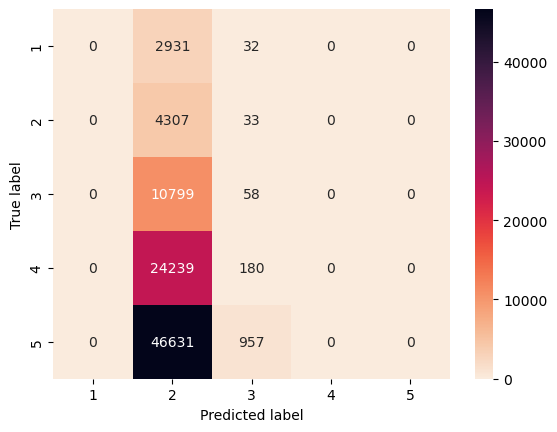

In [20]:
confusion_metrics = metrics.confusion_matrix (y_actual, y_pred_rating)
categories = ['1','2','3','4','5']
sns.heatmap(confusion_metrics, annot=True, fmt = '.0f',cmap=sns.color_palette("rocket_r", as_cmap=True), xticklabels=categories,yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label');

### Surprisingly, model's output is perfect (which mean something may be wrong). For our analysis, more important to have similar books together so that we can recommend

### Now we have a model that can predict the ratings. Our main goal is to recommend books based on user's personality types. The steps we will follow to do that:
- Categorize books in different clusters using K-Means clustering
- Get rough personality type for different book clusters
- Ask the user to enter a short bio that will be used to detect personality types; based on user personality type, refer books which belong to the cluster having a similar personality type 

#### We will use Hugging Face Bert personality model - https://huggingface.co/Minej/bert-base-personality -  to estimate personality type

### Now we will do K-means clustering. First we need to change the shape of the data so that the rows are for each book and the columns for the users, with values as the ratings that the users have provided

In [21]:
book_review_data.head(5)

Title  \
0                           Dr. Seuss: American Icon   
1                           Dr. Seuss: American Icon   
2                           Dr. Seuss: American Icon   
3              Wonderful Worship in Smaller Churches   
4  Rising Sons and Daughters: Life Among Japan's ...   

                                         description         authors  \
0  Philip Nel takes a fascinating look into the k...      Philip Nel   
1  Philip Nel takes a fascinating look into the k...      Philip Nel   
2  Philip Nel takes a fascinating look into the k...      Philip Nel   
3  This resource includes twelve principles in un...    David R. Ray   
4  Wardell recalls his experience as a foreign st...  Steven Wardell   

                       categories         User_id  Ratings  \
0  ['Biography', 'Autobiography']  A30TK6U7DNS82R      5.0   
1  ['Biography', 'Autobiography']  A2MVUWT453QH61      4.0   
2  ['Biography', 'Autobiography']  A2F6NONFUDB6UK      4.0   
3                    ['Religion']  A373VVEU6Z9M0N      5.0   
4              ['Social Science']  A3NIQK6ZLYEP1L      4.0   

                                    review/summary  \
0                                really enjoyed it   
1  phlip nel gives silly seuss a serious treatment   
2        one of americas greatest creative talents   
3        small churches can have wonderful worship   
4                         almost a day by day view   

                                         review/text  UserId  BookId  
0  i dont care much for dr seuss but after readin...       0       0  
1  theodore seuss geisel 19041991 aka quotdr seus...       1       0  
2  dr seuss american icon by philip nel is a thou...       2       0  
3  many small churches feel like they can not hav...       3       1  
4  steven wardell went to japan without reading a...       4       2

In [22]:
book_review_data = book_review_data.pivot(index='BookId', columns = "UserId", values="Ratings").fillna(0)
customer_order_info = merge_data_pivot.reset_index(drop=False).rename_axis(None, axis=1)
customer_order_info.head()

NameError: name 'merge_data_pivot' is not defined

In [ ]:
a = input()